# Importing Packages

In [81]:
import pandas as pd
import requests
import warnings
warnings.filterwarnings("ignore")
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

%reload_ext autoreload
%autoreload 2
from config import keys
from utils import *

import re
import gensim
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns


# Twitter API and Importing Datasets

## Davidson Dataset

In [4]:
df = pd.read_csv("data/labeled_data.csv", index_col=0)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df = df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
df.columns = ['label', 'text']
df.label.value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [6]:
df = df.replace({'label': {1: 0, 2: 0, 0: 1}})
df.label.value_counts()

0    23353
1     1430
Name: label, dtype: int64

In [7]:
df.head()

,label,text
0,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Aristotle Dataset

In [8]:
df2 = pd.read_csv("data/hatespeechtwitter.csv")
df2.head()

,tweet_id,maj_label
0,849667487180259329,abusive
1,850490912954351616,abusive
2,848791766853668864,abusive
3,848306464892604416,abusive
4,850010509969465344,normal


In [9]:
df2.columns = ['id', 'label']
df2.label.value_counts()

normal     52835
spam       13404
abusive    10122
hateful     3635
Name: label, dtype: int64

In [10]:
# setup url and headers for calling Twitter API as per documentation
url = "https://api.twitter.com/2/tweets?ids=847661947159891972,847799130277675008,848933211375779840&tweet.fields=created_at,entities,geo,id,public_metrics,text&user.fields=description,entities,id,location,name,public_metrics,username"
payload={}
headers = {'Authorization': 'Bearer ' + keys['bearer_token'], 'Cookie': 'personalization_id="v1_hzpv7qXpjB6CteyAHDWYQQ=="; guest_id=v1%3A161498381400435837'}

# make GET request to Twitter API to get response object 
r = requests.request("GET", url, headers=headers, data=payload)

# convert payload to dictionary
data = r.json()

In [11]:
df_hateful = df2[df2['label']=='hateful']
hate_ids = group_list(list(df_hateful.id))

In [12]:
df_hate = tweets_request(hate_ids)

100%|██████████| 37/37 [00:20<00:00,  1.79it/s]


In [13]:
df_hate['label'] = 1
df_2 = df_hate[['text', 'label']]
df_2.head()

,text,label
0,I hate er chase because if the Bitch that work...,1
1,RT @nyctophil3: Pineapples do not belong on pi...,1
2,Niggas keep talking about women wearing weave ...,1
3,@vappywave idiot that's not gonna work. you go...,1
4,RT @ayevonnn: bruh i fucking hate people like ...,1


## University of Copenhagen Dataset

In [14]:
df3 = pd.read_csv('data/NAACL_SRW_2016.csv')
df3.head()

,572342978255048705,racism
0,572341498827522049,racism
1,572340476503724032,racism
2,572334712804384768,racism
3,572332655397629952,racism
4,575949086055997440,racism


In [15]:
df3.columns = ['id', 'label']
df3.label.value_counts()

none      11559
sexism     3378
racism     1969
Name: label, dtype: int64

In [16]:
df_racsex = df3[(df3['label']=='racism') | (df3['label']=='sexism')]
racsex_id = group_list(list(df_racsex.id))
df_rac_sex = tweets_request(racsex_id)

100%|██████████| 54/54 [00:26<00:00,  2.06it/s]


In [17]:
df_rac_sex['label'] = 1
df_3 = df_rac_sex[['text', 'label']]
df_3.head()

,text,label
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
0,RT @YesYoureRacist: At least you're only a tin...,1


## HASOC Dataset

In [18]:
df4 = pd.read_csv("data/english_dataset.tsv", delimiter = "\t")
df4.head()

,text_id,text,task_1,task_2,task_3
0,hasoc_en_1,#DhoniKeepsTheGlove | WATCH: Sports Minister K...,NOT,NONE,NONE
1,hasoc_en_2,@politico No. We should remember very clearly ...,HOF,HATE,TIN
2,hasoc_en_3,@cricketworldcup Guess who would be the winner...,NOT,NONE,NONE
3,hasoc_en_4,Corbyn is too politically intellectual for #Bo...,NOT,NONE,NONE
4,hasoc_en_5,All the best to #TeamIndia for another swimmin...,NOT,NONE,NONE


In [19]:
df_4 = df4[df4.task_2 == 'HATE']
df_4['label'] = 1
df_4 = df_4[['text', 'label']]
df_4.head()

,text,label
1,@politico No. We should remember very clearly ...,1
11,I don’t know how much more I can take! 45 is a...,1
23,#ShameOnICC 1. ICC on Dhoni's gloves ...,1
27,Disgusting! And they don’t change their cultur...,1
34,"@TheRealOJ32 Of all the retired NFL players, w...",1


## Combined Dataframe

In [20]:
combined = pd.concat([df, df_2, df_3, df_4], ignore_index=True)
combined.label.value_counts()

0    23353
1     7031
Name: label, dtype: int64

In [24]:
combined.to_csv("data/combined.csv")

In [57]:
# separate into hate and not-hate subsets
hate = combined[combined.label == 1]
not_hate = combined[combined.label == 0]

# separate into features and target for train_test_aplit
X_hate = hate.text
y_hate = hate.label
X_not_hate = not_hate.text
y_not_hate = not_hate.label

# perform 80-20 split on dataset
X_hate_tr, X_hate_val, y_hate_tr, y_hate_val = train_test_split(X_hate, y_hate, test_size=0.20, random_state=42)
X_not_hate_tr, X_not_hate_val, y_not_hate_tr, y_not_hate_val = train_test_split(X_not_hate, y_not_hate, test_size=0.20, random_state=42)

# concatenate to reform training and validation dataset
X_train = pd.concat((X_hate_tr, X_not_hate_tr), ignore_index=True)
y_train = pd.concat((y_hate_tr, y_not_hate_tr), ignore_index=True)
train = pd.concat([X_train, y_train], axis=1)

X_val = pd.concat((X_hate_val, X_not_hate_val), ignore_index=True)
y_val = pd.concat((y_hate_val, y_not_hate_val), ignore_index=True)
valid = pd.concat([X_val, y_val], axis=1)

# Preprocessing Tweets

In [59]:
train.text = train.text.apply(lambda x: preprocess(x))
train.head()

,text,label
0,guy dare criminals rapist delhi crimefree usua...,1
1,kat get new decent hair cut,1
2,sexist hate hear female rappers switch song he...,1
3,bus woman drivers late sexist observation,1
4,seriously resistors need hijack rally buy tick...,1


In [60]:
valid.text = valid.text.apply(lambda x: preprocess(x))
valid.head()

,text,label
0,love talk bigly tail legs party country retire,1
1,america person murder wife treat like hero ins...,1
2,follow block murderer,1
3,claim bisexuals idiot gay,1
4,explain wage gap cite figure reference,1


# Modeling and Evaluation

In [63]:
X_train = train.text.values
X_valid = valid.text.values
y_train = train.label.values
y_valid = valid.label.values

vec = TfidfVectorizer()
tfidf_train = vec.fit_transform(X_train)
tfidf_valid = vec.transform(X_valid)

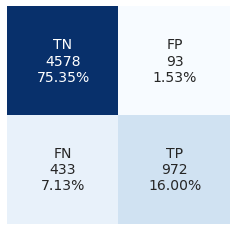

In [31]:
get_confusion(y_val, y_pred)

# Prediction

In [26]:
str1 = "@canelo28969897 @ItsCandyyyyyyy @DiamondRhona @darrel30901325 @Noblenosey Don’t nobody want no damn white man ew &amp;… https://t.co/cuzxJAzFGL" 
str2 = "@user lol speak for your own hazara(mongol) people who have nothing to do with ethnic afghans (nor genetical\u2026 @URL"


In [29]:
pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer()),
                           ('model', SVC(C=10, gamma=0.1, kernel='sigmoid', random_state=42))])
pipeline.fit(X_tr, y_tr)
str_2 = [preprocess(str2)]
result = pipeline.predict(str_2)

In [33]:
mapping = {0: 'Same tweet different day', 1: 'Why you gotta be so hateful?'}
print(mapping[result[0]])

Why you gotta be so hateful?


In [34]:
str_1 = [preprocess(str1)]
result2 = pipeline.predict(str_1)
print(mapping[result2[0]])

Why you gotta be so hateful?
